In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split, \
                                    RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from scipy.stats import uniform

Using TensorFlow backend.
D:\Program_Files\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Program_Files\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Program_Files\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Program_Files\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
from _common import NUM_LABEL_COLS, RANDOM_SEED
from _all_saxes_xbrass_lmsc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_all_saxes_xbrass_lmsc.py`.

Reading lmsc_data_0.pkl...
(725, 9230)
Reading lmsc_data_1.pkl...
(755, 9230)
Appending 1...
Reading lmsc_data_2.pkl...
(761, 9230)
Appending 2...
Reading lmsc_data_3.pkl...
(770, 9230)
Appending 3...
Reading lmsc_data_4.pkl...
(747, 9230)
Appending 4...
Reading lmsc_data_5.pkl...
(737, 9230)
Appending 5...
Reading lmsc_data_6.pkl...
(763, 9230)
Appending 6...
Reading lmsc_data_7.pkl...
(744, 9230)
Appending 7...
Reading lmsc_data_8.pkl...
(736, 9230)
Appending 8...
Making labels...
(6738, 9231)
Selecting columns...
(6738, 9216)
Trying to make numpy...
Applying scaler...
Done


In [3]:
"""
Import from this file if you're doing stuff with

        ALL SAXES XBRASS LOG MEL SPECTROGRAM
        COMPRESSED to 96 x 96

C. Cafiero
B. Gamble
M. Thompson
"""

import os

import pandas as pd
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS

TEST_SIZE = 0.20  # of total data
VALIDATION_SIZE = 0.2  # of training set
BANDS = 96
TIME_SLICES = 96

pnums = [0, 1, 2, 3, 4, 5, 6, 7, 8]
DIR = './data/'

for n in pnums:
    fn = 'lmsc_data_{}.pkl'.format(n)
    print("Reading lmsc_data_{}.pkl...".format(n))
    df = pd.read_pickle(os.path.join(DIR, fn))

    # exclude records we want to exclude
    df = df[df['trmp'] == '0']
    df = df[df['trmb'] == '0']
    df = df[df['otrb'] == '0']
    df = df[df['ext'] == '0']
    df = df[df['excl'] == '0']
    df = df[df['clrt'] == '0']
    df = df[df['othr'] == '0']

    print(df.shape)
    if n == 0:
        master = df
    else:
        print("Appending {}...".format(n))
        master = master.append(df)


print("Making labels...")
master['sax'] = master[['sop', 'alto', 'tenr', 'tora', 'bari']].max(axis=1)
master['sax'] = master['sax'].astype(int)
target = master['sax'].to_numpy().ravel()
# ^ these are the labels

print(master.shape)
print("Selecting columns...")
lmss = master.iloc[:, 1:]                           # off by one?
num_x_cols = lmss.shape[1] - NUM_LABEL_COLS - 1
lmss = lmss.iloc[:, 0:num_x_cols]
print(lmss.shape)

# print(lmss.head())
print("Trying to make numpy...")
data = lmss.to_numpy()

print("Applying scaler...")
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

print("Done")


Reading lmsc_data_0.pkl...
(714, 9230)
Reading lmsc_data_1.pkl...
(734, 9230)
Appending 1...
Reading lmsc_data_2.pkl...
(747, 9230)
Appending 2...
Reading lmsc_data_3.pkl...
(754, 9230)
Appending 3...
Reading lmsc_data_4.pkl...
(734, 9230)
Appending 4...
Reading lmsc_data_5.pkl...
(714, 9230)
Appending 5...
Reading lmsc_data_6.pkl...
(745, 9230)
Appending 6...
Reading lmsc_data_7.pkl...
(726, 9230)
Appending 7...
Reading lmsc_data_8.pkl...
(720, 9230)
Appending 8...
Making labels...
(6588, 9231)
Selecting columns...
(6588, 9216)
Trying to make numpy...
Applying scaler...
Done


In [4]:
x_train, x_test, y_train, y_test = \
    train_test_split(data, target, \
        test_size=TEST_SIZE, \
        random_state=RANDOM_SEED)

In [5]:
print(x_train.shape)
print(x_test.shape)

(5270, 9216)
(1318, 9216)


In [6]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

In [7]:
dependencies = {
    'recall': Recall
}

fn = './models/CNN/tenor_cnn/tenor_cnn_G.h5'
model = load_model(fn, custom_objects=dependencies, compile=False)

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1318/1318 [==============================] - 9s 7ms/step
Recall: 96.02
Accuracy: 94.31


In [12]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 95, 95, 128)       640       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 95, 95, 128)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 47, 47, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 46, 46, 128)       65664     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 46, 46, 128)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 128)     

In [13]:
 probas_pred = model.predict_proba(x_test)

In [14]:
 y_true = [1 if x == 1 else 0 for x in y_test]

In [15]:
 precision, recall, threshold = precision_recall_curve(y_true, probas_pred)

Text(0.5, 1.0, 'Precision-Recall Curve')

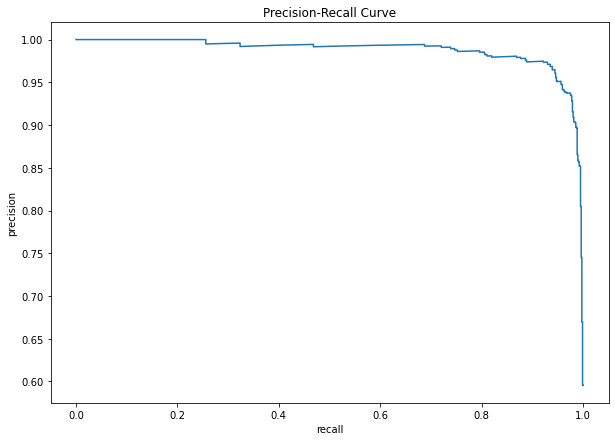

In [16]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")

In [17]:
fpr, tpr, threshold = roc_curve(y_true, probas_pred)
auc = roc_auc_score(y_true, probas_pred)

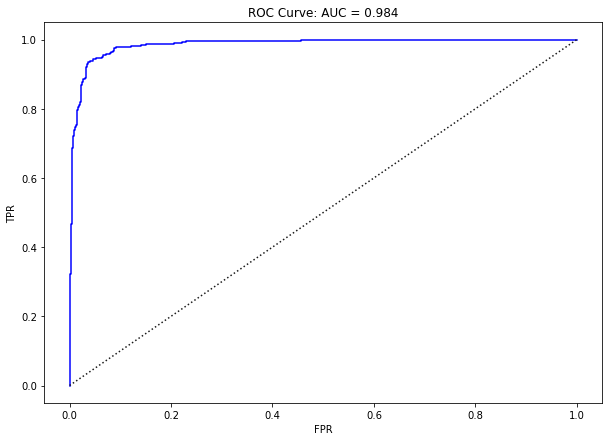

In [18]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 

plt.savefig('CNN_LMS_G_ROC.png', transparent=True)